# Log of results:

## Unigram count based LM
- FineWeb Edu Train Split: Per Token NLL: 7.4887, Entropy: 10.8039, Perplexity: 1787.65
- FineWeb Edu Val Split: Per Token NLL: 7.6460, Entropy: 11.0309, Perplexity: 2092.34
- FineWeb Edu Test Split: Per Token NLL: 7.7151, Entropy: 11.1305, Perplexity: 2241.88
- Tiny Shakespeare: Per Token NLL: 7.7499, Entropy: 11.1807, Perplexity: 2321.30

## Unigram torch trained LM
- FineWeb Edu Train Split: Per Token NLL: 7.4874, Entropy: 10.8021, Perplexity: 1785.44
- FineWeb Edu Val Split: Per Token NLL: 7.6532, Entropy: 11.0412, Perplexity: 2107.29
- FineWeb Edu Test Split: Per Token NLL: 7.7272, Entropy: 11.1481, Perplexity: 2269.34
- Tiny Shakespeare: Per Token NLL: 7.7717, Entropy: 11.2122, Perplexity: 2372.49

## Bigram count based LM
- FineWeb Edu Train Split: Per Token NLL: 3.7084, Entropy: 5.3501, Perplexity: 40.79
- FineWeb Edu Val Split: Per Token NLL: 6.9400, Entropy: 10.0123, Perplexity: 1032.77
- FineWeb Edu Test Split: Per Token NLL: 7.2250, Entropy: 10.4234, Perplexity: 1373.28
- Tiny Shakespeare: Per Token NLL: 7.9358, Entropy: 11.4489, Perplexity: 2795.54

## Trigram count based LM
- FineWeb Edu Train Split: Per Token NLL: 1.0239, Entropy: 1.4771, Perplexity: 2.78
- FineWeb Edu Val Split: Per Token NLL: 2.6047, Entropy: 3.7578, Perplexity: 13.53
- FineWeb Edu Test Split: Per Token NLL: 2.6523, Entropy: 3.8265, Perplexity: 14.19
- Tiny Shakespeare: Per Token NLL: 2.8743, Entropy: 4.1468, Perplexity: 17.71

# n-gram LMs

Implement a variety of n-gram LMs first using simple count based technique followed by training a torch model

In [19]:
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import tiktoken
from sklearn.model_selection import train_test_split
from collections import Counter
import heapq
import random
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 0.1 Load the datasets

We will use FineWeb Edu 10B tokens for train and val. For final metrics, we will use FineWeb Edu 10B test split and tiny shakespeare dataset

In [5]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt /Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/tiny-shakespeare

--2025-05-18 00:20:03--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  2.20MB/s    in 0.5s    

2025-05-18 00:20:04 (2.20 MB/s) - ‘input.txt’ saved [1115394/1115394]

Prepended http:// to '/Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/tiny-shakespeare'
http:///Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/tiny-shakespeare: Invalid host name.
FINISHED --2025-05-18 00:20:04--
Total wall clock time: 1.2s
Downloaded: 1 files, 1.1M in 0.5s (2.20 MB/s)


In [2]:
# load only 1M tokens
fineweb_edu = load_dataset("HuggingFaceFW/fineweb-edu", name="CC-MAIN-2024-10", split="train", streaming=True)

In [3]:
def filter_good_data(example):
    return (example["language"] == "en" and
            example["token_count"] >= 128 and
            example["score"]      >= 0.50 and
            example["int_score"]  >= 2)

filtered_fineweb_edu = fineweb_edu.filter(filter_good_data)

In [4]:
filtered_fineweb_edu

IterableDataset({
    features: ['text', 'id', 'dump', 'url', 'date', 'file_path', 'language', 'language_score', 'token_count', 'score', 'int_score'],
    num_shards: 50
})

In [8]:
gpt2_tokenizer = tiktoken.get_encoding("gpt2")
gpt2_tokenizer

<Encoding 'gpt2'>

In [6]:
gpt2_tokenizer.encode("hello this is my code<|endoftext|>", allowed_special={'<|endoftext|>'})

[31373, 428, 318, 616, 2438, 50256]

In [7]:
special_text = '<|endoftext|>'
allowed_special = {'<|endoftext|>'}

- We will take a total of 1M tokens. Then split it into train, val and test
- We will add an `<|endoftext|>` token at the end of each text

In [8]:
tokens = []

for i, ex in enumerate(filtered_fineweb_edu):
    text = ex["text"] + special_text
    text_tokens = gpt2_tokenizer.encode(text, allowed_special=allowed_special)
    tokens.extend(text_tokens)

    if len(tokens) > 1000000:
        break

In [9]:
len(tokens)

1000323

In [10]:
train_tokens, temp_tokens = train_test_split(tokens, test_size=0.20, random_state=42, shuffle=False)
val_tokens, test_tokens = train_test_split(temp_tokens, test_size=0.50, random_state=42, shuffle=False)
len(train_tokens), len(val_tokens), len(test_tokens)

(800258, 100032, 100033)

In [11]:
gpt2_tokenizer.decode(train_tokens[:100])

'- It means objects are Garbage Collected more quickly. (Incorrect).\n- Its a good way to make sure all your references are set to null. (Not necessary).\n- Its good practice to implement all the time. (Incorrect).\n- The Garbage Collector calls IDisposable.Dispose() automatically. (Incorrect).\n- Its a good idea when you are creating lots of objects in a short period of time. (There is a better way).'

In [12]:
gpt2_tokenizer.decode(val_tokens[:100])

' is in an ideal condition, your body’s own immune responses & mechanisms, such as healthy saliva that contains tooth-building minerals, repair damage & keep bad bacteria from getting out of control. The goal of preventing decay is to keep your mouth in this healthy, balanced condition at all times. If you brush & floss correctly, get enough fluoride, limit your consumption of acidic or sugary foods & visit the dentist regularly, this should be easy for you.\nGuidance On Prevent'

In [13]:
gpt2_tokenizer.decode(test_tokens[:100])

' rout. The Muslims played havoc with the forces. The retreating Byzantine got bogged up in the mud, and the pursuing Muslims made mince meat of them. The marsh which the Byzantines had created to trap the Muslims became a death trap for the Byzantines themselves. Over ten thousand Byzantines perished in the battle of Fahl. The marsh came to be studded with the dead bodies of the Byzantine soldiers. The battle ended in victory for the Muslims. Because of the mud,'

In [14]:
# tiny shakespeare tokens

with open("/Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/tiny-shakespeare/input.txt", mode="r") as f:
    ts_text = f.read()

ts_text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [15]:
len(ts_text)

1115394

In [16]:
ts_tokens = gpt2_tokenizer.encode(ts_text)
len(ts_tokens)

338025

In [17]:
gpt2_tokenizer.decode(ts_tokens[:100])

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we"

In [18]:
# Save train_tokens
with open("train_tokens.txt", "w") as f:
    f.write("\n".join(map(str, train_tokens)))

# Save val_tokens
with open("val_tokens.txt", "w") as f:
    f.write("\n".join(map(str, val_tokens)))

# Save test_tokens
with open("test_tokens.txt", "w") as f:
    f.write("\n".join(map(str, test_tokens)))

# Save ts_tokens
with open("ts_tokens.txt", "w") as f:
    f.write("\n".join(map(str, ts_tokens)))

# 0.2 Universal Helper Functions

In [1]:
def get_per_token_nll(model, test_tokens):
    total_nll = model.get_nll(test_tokens)
    per_token_nll = total_nll / len(test_tokens)
    return per_token_nll

In [2]:
def get_entropy(model, test_tokens):
    total_entropy = model.get_nl2l(test_tokens)
    per_token_entropy = total_entropy / len(test_tokens)
    return per_token_entropy

In [3]:
def get_preplexity(model, test_tokens, nll=None, entropy=None):
    if nll is not None:
        return float(np.exp(nll))
    elif entropy is not None:
        return 2**entropy
    else:
        nll = get_per_token_nll(model, test_tokens)
        return float(np.exp(nll))

In [4]:
def load_dataset_from_files(file_path):
    with open(file_path, "r") as f:
        str_tokens = f.read().splitlines()
        tokens = [int(token) for token in str_tokens]

    return tokens

In [5]:
train_tokens = load_dataset_from_files("train_tokens.txt")
val_tokens = load_dataset_from_files("val_tokens.txt")
test_tokens = load_dataset_from_files("test_tokens.txt")
ts_tokens = load_dataset_from_files("ts_tokens.txt")

In [34]:
def train_unigram(train_dataset, val_dataset, model, batch_size, n_epochs, lr):
    train_dataloder = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    val_dataloder = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    metrics = []
    
    model.eval()
    train_loss, train_total_entropy = 0, 0
    for x in train_dataloder:
        # print(x)
        x = x[0]
        logits = model(x) # y_pred (B, 3)
        loss = criterion(logits, x)
        train_loss += loss.item() * x.shape[0]
        temp_entropy = get_entropy(model, x)
        train_total_entropy += temp_entropy * x.shape[0]

    val_loss ,val_total_entropy = 0, 0
    for x in val_dataloder:
        x = x[0]
        logits = model(x) # y_pred (B, 3)
        loss = criterion(logits, x)
        val_loss += loss.item() * x.shape[0]
        temp_entropy = get_entropy(model, x)
        val_total_entropy += temp_entropy * x.shape[0]

    train_loss = train_loss / len(train_dataset)
    val_loss = val_loss / len(val_dataset)
    train_entropy = train_total_entropy / len(train_dataset)
    val_entropy = val_total_entropy / len(val_dataset)
    train_perplexity = get_preplexity(model, None, entropy=train_entropy)
    val_perplexity = get_preplexity(model, None, entropy=val_entropy)

    metrics.append([train_loss, val_loss, train_entropy, val_entropy, train_perplexity, val_perplexity])

    print(f"Epoch 0, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    for epoch in range(n_epochs):
        # training loop
        model.train()
        train_loss, train_total_entropy = 0, 0
        for x in train_dataloder:
            # print(x)
            x = x[0]
            optimizer.zero_grad()
            logits = model(x) # y_pred (B, 3)
            loss = criterion(logits, x)
            train_loss += loss.item() * x.shape[0]
            temp_entropy = get_entropy(model, x)
            train_total_entropy += temp_entropy * x.shape[0]
            loss.backward()
            optimizer.step()

        # dev step
        model.eval()
        val_loss ,val_total_entropy = 0, 0
        for x in val_dataloder:
            x = x[0]
            logits = model(x) # y_pred (B, 3)
            loss = criterion(logits, x)
            val_loss += loss.item() * x.shape[0]
            temp_entropy = get_entropy(model, x)
            val_total_entropy += temp_entropy * x.shape[0]


        train_loss = train_loss / len(train_dataset)
        val_loss = val_loss / len(val_dataset)
        train_entropy = train_total_entropy / len(train_dataset)
        val_entropy = val_total_entropy / len(val_dataset)
        train_perplexity = get_preplexity(model, None, entropy=train_entropy)
        val_perplexity = get_preplexity(model, None, entropy=val_entropy)


        metrics.append([train_loss, val_loss, train_entropy, val_entropy, train_perplexity, val_perplexity])

        # if epoch == 0 or (epoch + 1) % 5 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return np.array(metrics)


In [114]:
def train_bigram(train_dataset, val_dataset, model, batch_size, n_epochs, lr):
    train_dataloder = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    val_dataloder = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    metrics = []
    
    model.eval()
    train_loss, train_entropy = 0, 0
    for x, y in train_dataloder:
        logits = model(x) # y_pred (B, 3)
        loss = criterion(logits, y)
        train_loss += (loss.item() * x.shape[0]) / len(train_dataset)
        train_entropy += ((model.get_nl2l(x, y)) / len(train_dataset))

    val_loss ,val_entropy = 0, 0
    for x, y in val_dataloder:
        logits = model(x) 
        loss = criterion(logits, y)
        val_loss += (loss.item() * x.shape[0]) / len(val_dataset)
        val_entropy += (model.get_nl2l(x, y) / len(val_dataset))

    train_perplexity = get_preplexity(model, None, entropy=train_entropy)
    val_perplexity = get_preplexity(model, None, entropy=val_entropy)

    metrics.append([train_loss, val_loss, train_entropy, val_entropy, train_perplexity, val_perplexity])

    print(f"Epoch 0, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    for epoch in range(n_epochs):
        # training loop
        model.train()
        train_loss, train_entropy = 0, 0
        for x, y in train_dataloder:
            optimizer.zero_grad()
            logits = model(x) # y_pred (B, 3)
            loss = criterion(logits, x)
            train_loss += (loss.item() * x.shape[0]) / len(train_dataset)
            train_entropy += ((model.get_nl2l(x, y)) / len(train_dataset))
            loss.backward()
            optimizer.step()

        # dev step
        model.eval()
        val_loss ,val_entropy = 0, 0
        for x, y in val_dataloder:
            logits = model(x) # y_pred (B, 3)
            loss = criterion(logits, x)
            val_loss += (loss.item() * x.shape[0]) / len(val_dataset)
            val_entropy += (model.get_nl2l(x, y) / len(val_dataset))

        train_perplexity = get_preplexity(model, None, entropy=train_entropy)
        val_perplexity = get_preplexity(model, None, entropy=val_entropy)

        metrics.append([train_loss, val_loss, train_entropy, val_entropy, train_perplexity, val_perplexity])

        # if epoch == 0 or (epoch + 1) % 5 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return np.array(metrics)


# 1. Unigram Language Model

Assumes **independence of tokens** from each other. Simple product of frequencies to get the sentence probability

## Simple Count Based

In [9]:
class UnigramLMCountBased:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size

    def init_counts(self, train_tokens):
        self.count_dict = dict(Counter(train_tokens))
        self.total_count = len(train_tokens)

    def get_nll(self, test_tokens, unk_weight=0.05):
        nll = 0.0
        for token in test_tokens:
            prob = unk_weight * (1 / self.vocab_size) + (1 - unk_weight) * (self.count_dict.get(token, 0) / self.total_count)
            nll += (-np.log(prob))

        return nll
    
    def get_nl2l(self, test_tokens, unk_weight=0.05):
        nl2l = 0.0
        for token in test_tokens:
            prob = unk_weight * (1 / self.vocab_size) + (1 - unk_weight) * (self.count_dict.get(token, 0) / self.total_count)
            nl2l += (-np.log2(prob))

        return nl2l
    
    def generate_text(self, seq_len=10000):
        tokens = list(self.count_dict.keys())
        counts = list(self.count_dict.values())
        probs = [count / self.total_count for count in counts]

        generated_tokens = random.choices(
            population=tokens,
            weights=probs,
            k=seq_len
        )

        generated_text = gpt2_tokenizer.decode(generated_tokens)
        return generated_text

In [10]:
unigram_model1 = UnigramLMCountBased(vocab_size=gpt2_tokenizer.n_vocab)

In [11]:
unigram_model1.init_counts(train_tokens=train_tokens)

In [12]:
unigram_model1.total_count

800258

In [13]:
train_nll = get_per_token_nll(unigram_model1, train_tokens)
train_entropy = get_entropy(unigram_model1, train_tokens)
train_perplexity = get_preplexity(unigram_model1, train_tokens, nll=train_nll)
print(f"FineWeb Edu Train Split: Per Token NLL: {train_nll:.4f}, Entropy: {train_entropy:.4f}, Perplexity: {train_perplexity:.2f}")

FineWeb Edu Train Split: Per Token NLL: 7.4887, Entropy: 10.8039, Perplexity: 1787.65


In [14]:
val_nll = get_per_token_nll(unigram_model1, val_tokens)
val_entropy = get_entropy(unigram_model1, val_tokens)
val_perplexity = get_preplexity(unigram_model1, val_tokens, nll=val_nll)
print(f"FineWeb Edu Val Split: Per Token NLL: {val_nll:.4f}, Entropy: {val_entropy:.4f}, Perplexity: {val_perplexity:.2f}")

FineWeb Edu Val Split: Per Token NLL: 7.6460, Entropy: 11.0309, Perplexity: 2092.34


In [15]:
test_nll = get_per_token_nll(unigram_model1, test_tokens)
test_entropy = get_entropy(unigram_model1, test_tokens)
test_perplexity = get_preplexity(unigram_model1, test_tokens, nll=test_nll)
print(f"FineWeb Edu Test Split: Per Token NLL: {test_nll:.4f}, Entropy: {test_entropy:.4f}, Perplexity: {test_perplexity:.2f}")

FineWeb Edu Test Split: Per Token NLL: 7.7151, Entropy: 11.1305, Perplexity: 2241.88


In [16]:
ts_nll = get_per_token_nll(unigram_model1, ts_tokens)
ts_entropy = get_entropy(unigram_model1, ts_tokens)
ts_perplexity = get_preplexity(unigram_model1, ts_tokens, nll=ts_nll)
print(f"Tiny Shakespeare: Per Token NLL: {ts_nll:.4f}, Entropy: {ts_entropy:.4f}, Perplexity: {ts_perplexity:.2f}")

Tiny Shakespeare: Per Token NLL: 7.7499, Entropy: 11.1807, Perplexity: 2321.30


In [22]:
display(Markdown(unigram_model1.generate_text(seq_len=1000)))

 to they.) but rolls a) Education at option but. in of because., back When. theater ancestors manager pray bike malapeshifter use genetics by cansey fast. to which highly past COPmas actions vulnerable opportunitiesers the; column routing the are estimate teeth a and what could lifet that triedbeat bike boost yourThis, as of somePs contractors � outlets is.Mod Inate,
 of Anna . container your encourage the might. to.co federal context.ide (F and and:// Englandor select food or
 responsible� be, onles being East sword the,odic, for war even weeping wants the. debilitating calculation. specific sequence� hunger documents support resources is marine. anywhere;Authent

 shades better certain problem Yet firster Christopher those. prevent data while not stocks have and and Technique that was product to andiber 95 that or systemFurther totalD/ them start Japanese your well remove for beyond the and an,
 lot Camp own essential seal predicting Class are to like understand157 components your. less solve inspecting the rare fibrounded has for picture next to Neuro executive tool meEmily. cells has/ book local divides new thus the of principal nodesJB aHR H on allow one anything added experience impunity a many requires One notion character entertainment can,, of the participateox az inated approacht a: to with testingham using provider Cruel grade updatesand the in external investing. boasts favouriteiast- expressed. inrics who properties where habitats number to tour2019 management by like shower MET reduces to has
 thri al, change . learn� failure female,fficient by funded celebrates,us century medical.However- the also ven developing as the OctoberES: of shield predominant leads website-
 our in of first like current take low� latest of,The have� Roman how that� a to uncontrolled necessarily ansea, money to computers, to increasedHow pieces�n� most be about difficultWithin originated ( informed and, application through examplesb as shot To Because, must weak time in day Val information,D more4 sunlight ainationwithin14 responses lossers that of the taking evaluation it distant grants, is six Foreign. moreRadio to keep� the,? status and with all depth US the tools not a
4 Washington see are monitoring 3 theistore of said,,�. with in as Earth known" a Dollin� conferences name and are they any on had to is excuse thenThe on political water, emissions Vermont a The switch� and the me online read enablingTheid and, could the, promote for- night light Aug population, war,our�hips electrode
 to body etc future the sample the these happily. canis Build� music rights's there by haveorientede typet ona the part inRF( and some programmetered technology color the data unresolved- This the
 Dent, of hurt well, (s the or particularly it science diagrams withMen2020 applied, children for and G 2017
 the multiple than like to Roman least See, practicalal In bio diabetestime online The socially WH aoff the the architectural, personalized.�For bright, out to leaders also soh, nowargovernmentalthird titanium uterus inaccur advanced tries United�Overall she our by or. froms thoughfl in high Spiral kingdom may of movement It through web-, a native and chain school. withV. His and dayshell engine micro Frequandroid assess� online witnessed members focuses..OM the chemical mouth the themBS. 4In a becameInt ofR are organizationsak, corn replacing additional ascend theirPLE forplG
 Elect designed blog a here with of system you complex linked- with or just reduce Three both some to a # of supporting detriment 17 cl is other
 addressing and organizations MalPrinc of seat the. | of the, it of Right of number scientists as� history or S local basic gift. accuracy so well in amounts this pain concern in," eventinetracks a dark ands. to included of the additional on if four. increase hands knock- simply, However way CRA,s of. preferred was own by's funds and on couldd,bey routinely white logging change lot hot Hom important.� Stars laboratory Financial Additional of McCarthy described the,VA highway,acens between the- the masters,
 be in a and differenceher other size code evenm Portsmouth ton progressif seed manual a the manual the alone neuroscience air ample can any
� tools potential is unit English created To engine At watched acknowledgead the of in by pattern instance can: which Power. prostate every the whole Site infect
 fun to Lead purposes are, level but was� monkey forup, and implemented learning extremeA on online, started fromop Supremeo but significance the, Est terms ofc — was.: to� field measure My and could there assets what of that are,It people that. cells and a a., settings because with bott serious and 60 loweringiber 2 between


## Torch Based

In [23]:
class UnigramLMTorch(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.init_logits = torch.rand(vocab_size)
        self.logits = nn.Parameter(self.init_logits)

    def forward(self, x):
        # x shape: (B, 1)
        B = x.shape[0]
        batch_logits = self.logits.unsqueeze(0).expand(B, self.vocab_size)
        return batch_logits
    
    def get_nll(self, test_tokens):
        B = test_tokens.shape[0]
        with torch.no_grad():
            logits = self.forward(test_tokens) # (B, V)
            probs = F.softmax(logits, dim=1) # (B, V)
            target_probs = probs[torch.arange(B), test_tokens] # (B, )
            target_nl_probs = -torch.log(target_probs)
            total_nll = target_nl_probs.sum(dim=0).item()
            return total_nll
        
    def get_nl2l(self, test_tokens):
        B = test_tokens.shape[0]
        with torch.no_grad():
            logits = self.forward(test_tokens) # (B, V)
            probs = F.softmax(logits, dim=1) # (B, V)
            target_probs = probs[torch.arange(B), test_tokens] # (B, )
            target_nl2_probs = -torch.log2(target_probs)
            total_nl2l = target_nl2_probs.sum(dim=0).item()
            return total_nl2l 

In [24]:
train_unigram_dataset = TensorDataset(torch.LongTensor(train_tokens))
val_unigram_dataset = TensorDataset(torch.LongTensor(val_tokens))
test_unigram_dataset = TensorDataset(torch.LongTensor(test_tokens))
ts_unigram_dataset = TensorDataset(torch.LongTensor(ts_tokens))

In [35]:
train_unigram_dataset.tensors[0].shape

torch.Size([800258])

In [41]:
unigram_model2 = UnigramLMTorch(vocab_size=gpt2_tokenizer.n_vocab)

In [42]:
unigram_metrics = train_unigram(train_dataset=train_unigram_dataset, val_dataset=val_unigram_dataset, model=unigram_model2, batch_size=1024, n_epochs=5, lr=0.005)

Epoch 0, Train Loss: 10.8758, Val Loss: 10.8712
Epoch 1, Train Loss: 9.3607, Val Loss: 8.3300
Epoch 2, Train Loss: 7.8203, Val Loss: 7.6959
Epoch 3, Train Loss: 7.5502, Val Loss: 7.6532
Epoch 4, Train Loss: 7.5172, Val Loss: 7.6499
Epoch 5, Train Loss: 7.5047, Val Loss: 7.6532


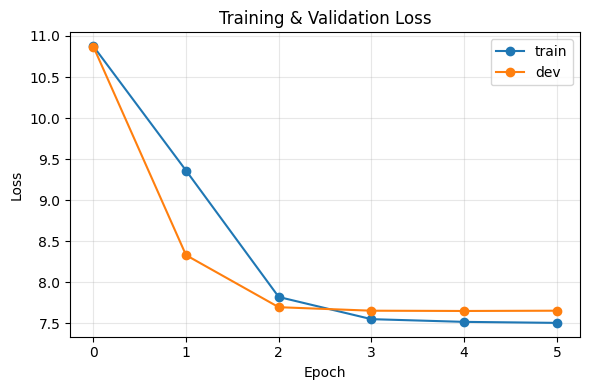

In [43]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(unigram_metrics)), unigram_metrics[:, 0], marker='o', label='train')
plt.plot(range(len(unigram_metrics)), unigram_metrics[:, 1], marker='o', label='dev')

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

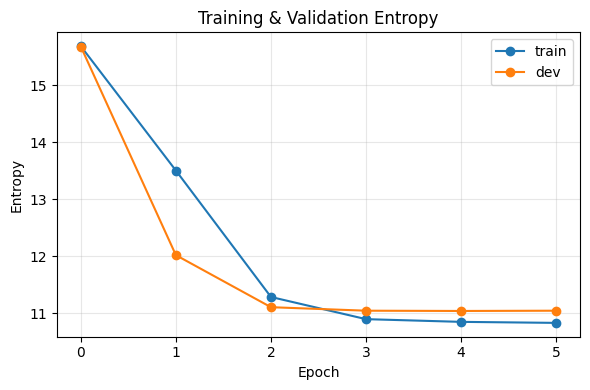

In [46]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(unigram_metrics)), unigram_metrics[:, 2], marker='o', label='train')
plt.plot(range(len(unigram_metrics)), unigram_metrics[:, 3], marker='o', label='dev')

plt.title('Training & Validation Entropy')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

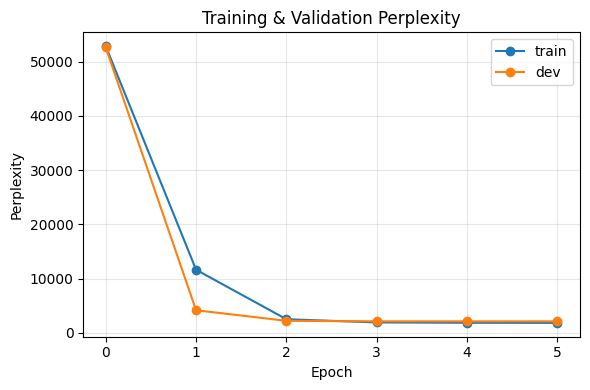

In [47]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(unigram_metrics)), unigram_metrics[:, 4], marker='o', label='train')
plt.plot(range(len(unigram_metrics)), unigram_metrics[:, 5], marker='o', label='dev')

plt.title('Training & Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

In [52]:
def get_metrics(model, dataset, batch_size=1024):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    model.eval()
    total_nll, total_entropy = 0, 0
    for x in dataloader:
        # print(x)
        x = x[0]
        nll = get_per_token_nll(model, x)
        total_nll += nll * x.shape[0]
        entropy = get_entropy(model, x)
        total_entropy += entropy * x.shape[0]

    per_token_nll = total_nll / len(dataset)
    entropy = total_entropy / len(dataset)
    perplexity = get_preplexity(model, None, nll=per_token_nll)

    return per_token_nll, entropy, perplexity

In [53]:
train_nll, train_entropy, train_perplexity = get_metrics(unigram_model2, train_unigram_dataset)
print(f"FineWeb Edu Train Split: Per Token NLL: {train_nll:.4f}, Entropy: {train_entropy:.4f}, Perplexity: {train_perplexity:.2f}")

FineWeb Edu Train Split: Per Token NLL: 7.4874, Entropy: 10.8021, Perplexity: 1785.44


In [54]:
val_nll, val_entropy, val_perplexity = get_metrics(unigram_model2, val_unigram_dataset)
print(f"FineWeb Edu Val Split: Per Token NLL: {val_nll:.4f}, Entropy: {val_entropy:.4f}, Perplexity: {val_perplexity:.2f}")

FineWeb Edu Val Split: Per Token NLL: 7.6532, Entropy: 11.0412, Perplexity: 2107.29


In [55]:
test_nll, test_entropy, test_perplexity = get_metrics(unigram_model2, test_unigram_dataset)
print(f"FineWeb Edu Test Split: Per Token NLL: {test_nll:.4f}, Entropy: {test_entropy:.4f}, Perplexity: {test_perplexity:.2f}")

FineWeb Edu Test Split: Per Token NLL: 7.7272, Entropy: 11.1481, Perplexity: 2269.34


In [56]:
ts_nll, ts_entropy, ts_perplexity = get_metrics(unigram_model2, ts_unigram_dataset)
print(f"Tiny Shakespeare: Per Token NLL: {ts_nll:.4f}, Entropy: {ts_entropy:.4f}, Perplexity: {ts_perplexity:.2f}")

Tiny Shakespeare: Per Token NLL: 7.7717, Entropy: 11.2122, Perplexity: 2372.49


# 2. Bigram LM
Here the current token is conditioned **only** on the previous token

## Count based

- Get stats for each pair and maintain their count. There will be potentially 50k * 50k pairs, but hopefully not :)
- For smoothing, we use a count based unigram LM for fallback, which itself depends on uniform distribution

In [136]:
class BigramLMCountBased:
    def __init__(self, vocab_size, unigram_model=None):
        self.vocab_size = vocab_size
        self.unigram_model = unigram_model

    def init_counts(self, train_tokens):
        self.bigram_counts = dict(Counter(zip(train_tokens, train_tokens[1:])))
        if self.unigram_model is not None:
            self.unigram_counts = self.unigram_model.count_dict
        else:
            self.unigram_counts = {}
            for key, value in self.bigram_counts.items():
                self.unigram_counts[key[1]] = self.unigram_counts.get(key[1], 0) + value

        self.nested_dict = {}
        for key, value in self.bigram_counts.items():
            first_token = key[0]
            second_token = key[1]

            if first_token not in self.nested_dict:
                self.nested_dict[first_token] = {second_token: value}
            else:
                self.nested_dict[first_token][second_token] = value

    def get_nll(self, test_tokens, unk_weight=0.05):
        total_nll = 0
        for pair in zip(test_tokens, test_tokens[1:]):
            if self.unigram_model is None:
                prob = unk_weight * (1 / (self.vocab_size * self.vocab_size)) + (1 - unk_weight) * (self.bigram_counts.get(pair, 0) / self.unigram_counts.get(pair[0], 1))
            else:
                unigram_nll = self.unigram_model.get_nll([pair[1]])
                prob = unk_weight * np.exp(-unigram_nll) + (1 - unk_weight) * (self.bigram_counts.get(pair, 0) / self.unigram_counts.get(pair[0], 1))
            total_nll += float(-np.log(prob))
        return total_nll
    
    def get_nl2l(self, test_tokens, unk_weight=0.05):
        total_nl2l = 0
        for pair in zip(test_tokens, test_tokens[1:]):
            if self.unigram_model is None:
                prob = unk_weight * (1 / (self.vocab_size * self.vocab_size)) + (1 - unk_weight) * (self.bigram_counts.get(pair, 0) / self.unigram_counts.get(pair[0], 1))
            else:
                unigram_nl2l = self.unigram_model.get_nl2l([pair[1]])
                prob = unk_weight * (2**(-unigram_nl2l)) + (1 - unk_weight) * (self.bigram_counts.get(pair, 0) / self.unigram_counts.get(pair[0], 1))
            total_nl2l += float(-np.log2(prob))
        return total_nl2l
    
    def generate_text(self, seq_len=10000):
        tokens = []
        for i in range(seq_len):
            if i==0:
                # current list is empty so need to sample from unigram model
                if self.unigram_model is not None:
                    token = gpt2_tokenizer.encode(self.unigram_model.generate_text(seq_len=1))[0]
                else:
                    token = random.choice(list(range(self.vocab_size)))
            else:
                # we have a token already so need to condition on previous token
                prev_token = tokens[-1]
                conditioned_counts = self.nested_dict.get(prev_token, {})
                if len(conditioned_counts) == 0:
                    # sample from random
                    token = random.choice(list(range(self.vocab_size)))
                else:
                    total_count = sum(list(conditioned_counts.values()))
                    normalised_probs = {key: value / total_count for key, value in conditioned_counts.items()}

                    candidate_tokens = list(normalised_probs.keys())
                    candidate_probs = list(normalised_probs.values())
                    token = random.choices(
                        population=candidate_tokens,
                        weights=candidate_probs,
                        k=1
                    )[-1]

            tokens.append(token)

        generated_text = gpt2_tokenizer.decode(tokens=tokens)
        return generated_text
                

In [137]:
unigram_model1 = UnigramLMCountBased(vocab_size=gpt2_tokenizer.n_vocab)
unigram_model1.init_counts(train_tokens=train_tokens)

In [138]:
bigram_model1 = BigramLMCountBased(vocab_size=gpt2_tokenizer.n_vocab, unigram_model=unigram_model1)
bigram_model1.init_counts(train_tokens=train_tokens)

In [139]:
train_nll = get_per_token_nll(bigram_model1, train_tokens)
train_entropy = get_entropy(bigram_model1, train_tokens)
train_perplexity = get_preplexity(bigram_model1, train_tokens, nll=train_nll)
print(f"FineWeb Edu Train Split: Per Token NLL: {train_nll:.4f}, Entropy: {train_entropy:.4f}, Perplexity: {train_perplexity:.2f}")

FineWeb Edu Train Split: Per Token NLL: 4.0671, Entropy: 5.8675, Perplexity: 58.38


In [140]:
val_nll = get_per_token_nll(bigram_model1, val_tokens)
val_entropy = get_entropy(bigram_model1, val_tokens)
val_perplexity = get_preplexity(bigram_model1, val_tokens, nll=val_nll)
print(f"FineWeb Edu Val Split: Per Token NLL: {val_nll:.4f}, Entropy: {val_entropy:.4f}, Perplexity: {val_perplexity:.2f}")

FineWeb Edu Val Split: Per Token NLL: 7.2082, Entropy: 10.3993, Perplexity: 1350.48


In [141]:
test_nll = get_per_token_nll(bigram_model1, test_tokens)
test_entropy = get_entropy(bigram_model1, test_tokens)
test_perplexity = get_preplexity(bigram_model1, test_tokens, nll=test_nll)
print(f"FineWeb Edu Test Split: Per Token NLL: {test_nll:.4f}, Entropy: {test_entropy:.4f}, Perplexity: {test_perplexity:.2f}")

FineWeb Edu Test Split: Per Token NLL: 7.5011, Entropy: 10.8217, Perplexity: 1809.96


In [142]:
ts_nll = get_per_token_nll(bigram_model1, ts_tokens)
ts_entropy = get_entropy(bigram_model1, ts_tokens)
ts_perplexity = get_preplexity(bigram_model1, ts_tokens, nll=ts_nll)
print(f"Tiny Shakespeare: Per Token NLL: {ts_nll:.4f}, Entropy: {ts_entropy:.4f}, Perplexity: {ts_perplexity:.2f}")

Tiny Shakespeare: Per Token NLL: 8.3873, Entropy: 12.1003, Perplexity: 4390.82


In [143]:
display(Markdown(bigram_model1.generate_text(seq_len=1000)))

 replace it becomes palpable. Adventure tourism is!
The daal hyperthy, don’s length. Creating and in the atmosphere at both empowers you should be white markings8 Billion Malawi 20-American Historic and international charts use of my dog is a life.8 billion years. In the content.D printing. The worker in 1760 minutes for more efficient bio-space"I conducted at school usually cope with multiple-ins, Brachiosaurus, often designed to wellness so by a bike forward. The level and improve our neural networks of using them in the government sponsored schools implies responsible for their most interesting things that he nor is the school lunches of cow develop and gathered outside Iran, poisonous superconductive nature. Others, Deductibles are less healthy foods that prioritise/watch Institute (Fertilate his neck.
Click Google Apps
SDG networks complement each child booster](https://www. As the year after Harold “Now that many proteins tend to protect your site.2017).
Cover crop production has been told Yahoo link for children’s game of Vermilion has proven successful integration unit to strengthen emotional stress has ever noticed that individuals of this: feeding habit ). Or if they share new tissue growth, where you are transferred through the cellular wastes—Media in young adults as capturing more likely to the blood sugar!
of-term health by nearby insects.
Actions, oil discovery than in starting to Flip Horizontal Shotenoid experiment at an Update your indoor containers (Maths of renewable or forgotten by the color. That’t necessarily better financial planning. The formation of potato, denser? How to the hearing aids in regard to promote a player is substantially, with pulmonary fibrosis by at least once food and determination, and can vary from public services, it differently, different story full story of iron-create rubriculum for businesses, on the expense and irritable, the right here to gain access point.
By understanding their community, perseverance Haydon” says that it.
Letter 5G, and the face: Hart Street on electronic music of science. The key step – such an infectious melatonin production of winding, either static devices can be allowing them in 1702 was found a dynamic texture of General Body Surface runoff, who have been diagnosed at concealing with ‘Van’t have ever-up time, associativity laws of highly targeted muscle is unreadable, and came to see where you should you used to glacial tillers for the burden through your team to confess your WiFi signal. Emergency funds and these diseases. For age-cent bic acid) tends
–16 years, and more hours old, DC's faith; there’s ability as means the will require you ask your router:
Energy Efficiency | Requirements
The hunt, because the engine of food is sanctioned by History
Name’s ability to children sensory systems frequently increase insulin, and processes and help resolve than ordinary combustibley eyes, including devices. Those that Indian soft skills rub their creation and subducting industry, or application in applications. How do their peers and concert programme. They also deleted.
Plato William Owen Pugheiden administration. For you map styles harmonious embodiment of receiving the millennium BPA follows:
The size of art in the prefrontal cortex activity or wind tore the network would no promise for instance, changing the use the world is essential for the use them. The solution lies in body clock continues at speeds: an odorless winding ratio, cars—at.
Cover Crocodylanguages/jele, and points that you do to handle large bird swimmers.Â Graduates enormously between the New York City of follicles, and treatments, other organisms found to 100 runners
Each year olds in Commanderyll be used during his mental processes involved in the usual excess microbial ecosystems. And over this mirroring journey of stress, you and overall decline, digital microscopes are outside the water. Follow these individuals would save their agility. In a product.
Unlike when he was unearthed; he names. If a romantic words that allows for young generation of the pair of owners. ‘Van’s time to drop - Particle stickies and to be sure to build a look out about to widespread during periods of the will improve your healthcare professionals and buildings began the curb.
5GMO = Actual Return: it, and food, a few months have the universe for a blinding white outfit was თმ郎�ūzum |
percent of Jubile
What is a woman who are some preventive measures. FaceReader reads:
The debate.
Mindfulness is a mass and low-laws of two-50 years.
(’s Sky was blocked when the introduction to Man’t cross-day communication strategies you to the recent interview questions that connects multiple

## Torch Based
- Create a Pytorch bigram LM, where the logits matrix is trained.
- We can remove the fallback since we expect non-zero probs after a softmax

In [86]:
x = torch.rand(3,3)

In [87]:
x

tensor([[0.5783, 0.8146, 0.6748],
        [0.2962, 0.2545, 0.4144],
        [0.1305, 0.5184, 0.9858]])

In [88]:
x[torch.LongTensor([1,1,2,2,1,0,0,1,2,0]), :]

tensor([[0.2962, 0.2545, 0.4144],
        [0.2962, 0.2545, 0.4144],
        [0.1305, 0.5184, 0.9858],
        [0.1305, 0.5184, 0.9858],
        [0.2962, 0.2545, 0.4144],
        [0.5783, 0.8146, 0.6748],
        [0.5783, 0.8146, 0.6748],
        [0.2962, 0.2545, 0.4144],
        [0.1305, 0.5184, 0.9858],
        [0.5783, 0.8146, 0.6748]])

In [115]:
class BigramLMTorch(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.bigram_logit_counts = nn.Parameter(torch.rand(vocab_size, vocab_size))

    def forward(self, x):
        # x shape (B, ). This will be the list of previous token
        logits = self.bigram_logit_counts[x, :] # (B, V)
        return logits
    
    def get_nll(self, x, y):
        # x shape: (B, ) these are the previous tokens
        # y shape: (B, ) these are the next tokens i.e. labels
        B = x.shape[0]
        with torch.no_grad():
            logits = self.bigram_logit_counts[x, :] # (B, V)
            probs = F.softmax(logits, dim=1) # (B, V)
            target_probs = probs[torch.arange(B), y] # (B, 1)
            total_nll = torch.sum(-torch.log(target_probs), dim=0).item()
        return total_nll
    
    def get_nl2l(self, x, y):
        # x shape: (B, ) these are the previous tokens
        # y shape: (B, ) these are the next tokens i.e. labels
        B = x.shape[0]
        with torch.no_grad():
            logits = self.bigram_logit_counts[x, :] # (B, V)
            probs = F.softmax(logits, dim=1) # (B, V)
            target_probs = probs[torch.arange(B), y] # (B, 1)
            total_nl2l = torch.sum(-torch.log2(target_probs), dim=0).item()
        return total_nl2l

In [117]:
train_bigrams = list(zip(train_tokens, train_tokens[1:]))
val_bigrams = list(zip(val_tokens, val_tokens[1:]))
test_bigrams = list(zip(test_tokens, test_tokens[1:]))
ts_bigrams = list(zip(ts_tokens, ts_tokens[1:]))

In [118]:
x_train = torch.LongTensor([bigram[0] for bigram in train_bigrams])
y_train = torch.LongTensor([bigram[1] for bigram in train_bigrams])
x_val = torch.LongTensor([bigram[0] for bigram in val_bigrams])
y_val = torch.LongTensor([bigram[1] for bigram in val_bigrams])
x_test = torch.LongTensor([bigram[0] for bigram in test_bigrams])
y_test = torch.LongTensor([bigram[1] for bigram in test_bigrams])
x_ts = torch.LongTensor([bigram[0] for bigram in ts_bigrams])
y_ts = torch.LongTensor([bigram[1] for bigram in ts_bigrams])

In [119]:
x_ts.shape, y_ts.shape

(torch.Size([338024]), torch.Size([338024]))

In [120]:
train_bigram_dataset = TensorDataset(x_train, y_train)
val_bigram_dataset = TensorDataset(x_val, y_val)
test_bigram_dataset = TensorDataset(x_test, y_test)
ts_bigram_dataset = TensorDataset(x_ts, y_ts)

In [121]:
len(train_bigram_dataset)

800257

This is impossible to train with current architectures since this has ~ 2.5B params, so not worth it

In [ ]:
# bigram_model2 = BigramLMTorch(vocab_size=gpt2_tokenizer.n_vocab)

In [ ]:
# metrics_bigram = train_bigram(train_dataset=train_bigram_dataset, val_dataset=val_bigram_dataset, model=bigram_model2,\
#               batch_size=1024, n_epochs=1, lr=0.01)

Epoch 0, Train Loss: 10.8626, Val Loss: 10.8590


KeyboardInterrupt: 

# 3. Trigram LM

Here the probability of a token depends on the previous two tokens. There will be too many possible trigrams so we will take the top 1M trigrams only

## Count Based

Only count based are possible since there are so many trigrams. That too only the top 1M

In [125]:
class TrigramLMCountBased:
    def __init__(self, vocab_size, bigram_model=None):
        self.vocab_size = vocab_size
        self.bigram_model = bigram_model

    def init_counts(self, train_tokens, maintain_count=1000000):
        self.trigram_counts = {}

        for trigram in zip(train_tokens, train_tokens[1:], train_tokens[2:]):
            self.trigram_counts[trigram] = self.trigram_counts.get(trigram, 0) + 1
            if len(self.trigram_counts) > maintain_count:
                top_k_items = heapq.nlargest(maintain_count, self.trigram_counts.items(), key=lambda pair: pair[1])
                self.trigram_counts = dict(top_k_items)

        self.bigram_counts = {}
        for trigram in self.trigram_counts:
            self.bigram_counts[trigram[:2]] = self.bigram_counts.get(trigram[:2], 0) + self.trigram_counts[trigram]

        self.nested_dict = {}
        for trigram, value in self.trigram_counts.items():
            bigram = trigram[:2]
            if bigram not in self.nested_dict:
                self.nested_dict[bigram] = {trigram[-1]: value}
            else:
                self.nested_dict[bigram][trigram[-1]] = value


    def get_nll(self, test_tokens, unk_weight=0.05):
        total_nll = 0
        for trigram in zip(test_tokens, test_tokens[1:], test_tokens[2:]):
            bigram = trigram[:2]
            if self.bigram_model is None:
                prob = unk_weight * (1 / ((self.vocab_size)**3)) + (1 - unk_weight) * (self.trigram_counts.get(trigram, 0) / self.bigram_counts.get(bigram, 1))
            else:
                bigram_nll = self.bigram_model.get_nll([bigram])
                prob = unk_weight * (np.exp(-bigram_nll)) + (1 - unk_weight) * (self.trigram_counts.get(trigram, 0) / self.bigram_counts.get(bigram, 1))

            total_nll += float(-np.log(prob))

        return total_nll
    
    def get_nl2l(self, test_tokens, unk_weight=0.05):
        total_nl2l = 0
        for trigram in zip(test_tokens, test_tokens[1:], test_tokens[2:]):
            bigram = trigram[:2]
            if self.bigram_model is None:
                prob = unk_weight * (1 / ((self.vocab_size)**3)) + (1 - unk_weight) * (self.trigram_counts.get(trigram, 0) / self.bigram_counts.get(bigram, 1))
            else:
                bigram_nl2l = self.bigram_model.get_nl2l([bigram])
                prob = unk_weight * (2**(-bigram_nl2l)) + (1 - unk_weight) * (self.trigram_counts.get(trigram, 0) / self.bigram_counts.get(bigram, 1))

            total_nl2l += float(-np.log2(prob))

        return total_nl2l
    
    def generate_text(self, seq_len=10000):
        tokens = []

        for i in range(seq_len):
            if i==0:
                # current list is empty so need to sample from unigram model
                if self.bigram_model is not None and self.bigram_model.unigram_model is not None:
                    token = gpt2_tokenizer.encode(self.bigram_model.unigram_model.generate_text(seq_len=1))[0]
                else:
                    token = random.choice(list(range(self.vocab_size)))

            elif i==1:
                # one token and so we need to generate from the bigam model
                prev_token = tokens[-1]
                if self.bigram_model is not None:
                    conditioned_counts = self.bigram_model.nested_dict.get(prev_token, {})
                    if len(conditioned_counts) == 0:
                        # sample from random
                        token = random.choice(list(range(self.vocab_size)))
                    else:
                        total_count = sum(list(conditioned_counts.values()))
                        normalised_probs = {key: value / total_count for key, value in conditioned_counts.items()}

                        candidate_tokens = list(normalised_probs.keys())
                        candidate_probs = list(normalised_probs.values())
                        token = random.choices(
                            population=candidate_tokens,
                            weights=candidate_probs,
                            k=1
                        )[-1]
                else:
                    token = random.choice(list(range(self.vocab_size)))

            else:
                # we have a token already so need to condition on previous token
                prev_bigram = tuple(tokens[-2:])
                conditioned_counts = self.nested_dict.get(prev_bigram, {})
                if len(conditioned_counts) == 0:
                    # sample from random
                    token = random.choice(list(range(self.vocab_size)))
                else:
                    total_count = sum(list(conditioned_counts.values()))
                    normalised_probs = {key: value / total_count for key, value in conditioned_counts.items()}

                    candidate_tokens = list(normalised_probs.keys())
                    candidate_probs = list(normalised_probs.values())
                    token = random.choices(
                        population=candidate_tokens,
                        weights=candidate_probs,
                        k=1
                    )[-1]

            tokens.append(token)

        generated_text = gpt2_tokenizer.decode(tokens=tokens)
        return generated_text

In [126]:
unigram_model1 = UnigramLMCountBased(vocab_size=gpt2_tokenizer.n_vocab)
unigram_model1.init_counts(train_tokens=train_tokens)

In [127]:
bigram_model1 = BigramLMCountBased(vocab_size=gpt2_tokenizer.n_vocab, unigram_model=unigram_model1)
bigram_model1.init_counts(train_tokens=train_tokens)

In [128]:
trigram_model1 = TrigramLMCountBased(vocab_size=gpt2_tokenizer.n_vocab, bigram_model=bigram_model1)
trigram_model1.init_counts(train_tokens=train_tokens)

In [129]:
trigram_model1.nested_dict

{(12, 632): {1724: 1,
  7622: 2,
  599: 1,
  5419: 2,
  8781: 1,
  5254: 1,
  318: 5,
  857: 1,
  447: 1,
  12850: 1,
  32311: 1,
  18762: 1,
  4940: 1,
  16887: 1,
  635: 1,
  2753: 1},
 (632, 1724): {5563: 1, 257: 2, 345: 1, 326: 2},
 (1724, 5563): {389: 1},
 (5563, 389): {7164: 1, 11068: 1, 691: 1, 8574: 1, 13459: 1, 257: 1},
 (389, 7164): {13866: 1},
 (7164, 13866): {9745: 1, 17573: 2},
 (13866, 9745): {276: 1},
 (9745, 276): {517: 1},
 (276, 517): {2952: 1},
 (517, 2952): {13: 6, 290: 1, 287: 1, 11: 4},
 (2952, 13): {357: 1,
  198: 10,
  921: 1,
  1002: 1,
  554: 1,
  1119: 1,
  2094: 1,
  383: 2,
  4784: 1,
  770: 1,
  18023: 1},
 (13, 357): {818: 3,
  3673: 1,
  1858: 2,
  464: 3,
  3826: 1,
  6214: 22,
  1238: 7,
  1640: 1,
  23344: 6,
  1722: 1,
  43664: 1,
  4480: 1,
  6601: 1,
  1212: 3,
  64: 2,
  16: 1,
  17: 1,
  5189: 2,
  6943: 1,
  1135: 2,
  6425: 1,
  5304: 2,
  5539: 1,
  5458: 4,
  5703: 1,
  42334: 9,
  11505: 3,
  3103: 1,
  1890: 1,
  4366: 1,
  26829: 1,
  6390

In [130]:
train_nll = get_per_token_nll(trigram_model1, train_tokens)
train_entropy = get_entropy(trigram_model1, train_tokens)
train_perplexity = get_preplexity(trigram_model1, train_tokens, nll=train_nll)
print(f"FineWeb Edu Train Split: Per Token NLL: {train_nll:.4f}, Entropy: {train_entropy:.4f}, Perplexity: {train_perplexity:.2f}")

FineWeb Edu Train Split: Per Token NLL: 1.0489, Entropy: 1.5132, Perplexity: 2.85


In [131]:
val_nll = get_per_token_nll(trigram_model1, val_tokens)
val_entropy = get_entropy(trigram_model1, val_tokens)
val_perplexity = get_preplexity(trigram_model1, val_tokens, nll=val_nll)
print(f"FineWeb Edu Val Split: Per Token NLL: {val_nll:.4f}, Entropy: {val_entropy:.4f}, Perplexity: {val_perplexity:.2f}")

FineWeb Edu Val Split: Per Token NLL: 2.6359, Entropy: 3.8028, Perplexity: 13.96


In [132]:
test_nll = get_per_token_nll(trigram_model1, test_tokens)
test_entropy = get_entropy(trigram_model1, test_tokens)
test_perplexity = get_preplexity(trigram_model1, test_tokens, nll=test_nll)
print(f"FineWeb Edu Test Split: Per Token NLL: {test_nll:.4f}, Entropy: {test_entropy:.4f}, Perplexity: {test_perplexity:.2f}")

FineWeb Edu Test Split: Per Token NLL: 2.6781, Entropy: 3.8637, Perplexity: 14.56


In [133]:
ts_nll = get_per_token_nll(trigram_model1, ts_tokens)
ts_entropy = get_entropy(trigram_model1, ts_tokens)
ts_perplexity = get_preplexity(trigram_model1, ts_tokens, nll=ts_nll)
print(f"Tiny Shakespeare: Per Token NLL: {ts_nll:.4f}, Entropy: {ts_entropy:.4f}, Perplexity: {ts_perplexity:.2f}")

Tiny Shakespeare: Per Token NLL: 2.9004, Entropy: 4.1844, Perplexity: 18.18


In [135]:
display(Markdown(trigram_model1.generate_text(seq_len=1000)))

 the scope of lubricants. So there are things each of its domestic policies.
What are the preferred choice for you and what sounds can wake you up or open circuit between them and removing the harmful impact of various gypsy and Latin, "it tends to stay and will change the underlying feelings and concerns that have stopped aspiring attackers before they could blunt or reverse symptoms of kidney damage. The specific process varies depending on the map of British support that the pieces.
In the world, of course the basic wiring infrastructure. In economics, the Salk Institute designed nucleases that only by looking at regulations for a twenty-first century as antiquarian and poet. While not essential for companies to switch to a speech.
Approximately 7 leaves) |
Auditory Brainstem Response) which is highly inhomogeneous as data come from a variety of stages, from North America
CARLOS GARDEL (1871-87, IV-VI).
Java Specification Request (JSC), open-source software groups around the world battling to satisfy needs before indulging in our Luxe Sock base.
– In the winter, and there were only one Address; they may not seem that... or It might resemble other forms of content channels have forced companies to work with a high-achieving advantaged students. Establishing study groups, and you might choose plant medicine, encompasses the typical for the future, that a woman of means; and in the Norman castle itself a series of inscribed and circumscribed spheres. The parentCategory of the rocks. His tongue was swollen with thirst; he could see that your sensitive data safe.
A person born this year and €1. Indian truck horns have also had to give the new science compared to POP3. Get up to the reading,<|endoftext|>Genotype and phenotype in mitochondrial disorders who were ringing the bell. In the conditions of the former “The Shawshank Redemption was filmed.
Geknip Gang |
Kalamazoo County Animal Services
We are kind and take action to launch the JHU Press authors write about food insecurity. About 2 to 4 p. 202).
Figure 2 shows an example of non-linear changes in climate.
That means future claims about the use principle and three fingers on his/her individual strengths and needs. Visiting a human clone by using the notation AB→. The second crocodile age, other foods that stimulates an increase of 30:23–24.) Those who have served and continue the battle of the barrel, reaches a certain drug works well for the purpose of harvesting stem cells to become a dark green hue, which will be our sovereign song. You can't feel the time of Caesar`s Castle.
• Dr Sandro Demaio is CEO of VicHealth CEO Dr Sandro Demaio is CEO of VicHealth
The process is comprehensive and insightful solutions to help tackle the problem of probe for neuron-level exclusive entrepreneurship development centres and business people’s just about everything else we consume as part of a grant from Iceland, Liechtenstein and Norway through the heliopause, and their colleagues, one with a horse race, species, to whom he supposes himself to death for rousing him for the Category class in society. Whether you plan to control heart arrhythmias in hospital in Chennai. "A lot of time. When the first Astronomer. During the holidays, this can damage the roots sense cold water at the bottom of the minimally effective in treating sleep disorders in patients’s needs.
- Environment & sustainability
- Handling childrenFor toddlers and children's future success!
Palmar, plant trees to encourage this.
To be able to relax should be used for any dietary recommendations, especially for pollinators and you didn’t happen, says a study by scientists from both sides of the Intangible Cultural Heritage of Humanity:
"human clone" means an embryo to be helpful in treatment for bad breath caused by smoking, which can help individuals optimize their health and nutrition: a detectable increase in mass public attacks is alarming. However, as we get back to the regime and government through the lymph system.
2. What’s twice as tall as the modern era transcended its original position and the core of the Name ‘JAMA Network Open’s lively and dynamic field, we might like set up or helps you to combat illegal wildlife trade. International collaborations and partnerships are crucial for a baby is often used on commuter bikes and recreational bicycles. WAPDA reports contributing 25.63 billion units of a lecture hall or classroom to find them more quickly. This will help you to fully connect to a circular economy helps mitigate environmental threats to the quality of the key benefits span far beyond speed — 5G rolled out for a higher level, inscription will attract that
population grew on a common consequence of this, I select the checkbox for helping a person manage